Josephson Junction-Based Quantum MaxCut Solver

In this tutorial we will explain the implementinion of a Josephson junction (JJ)-inspired quantum MaxCut solver.

\section{Physical Model: Josephson Junction}

A current-biased Josephson junction is described by the \emph{tilted washboard potential}, where the phase difference across the junction behaves like a particle in a potential well. The energy barrier for escape is given by:

\begin{equation}
\Delta U(I_b, I_c) = 2 \frac{I_c \Phi_0}{2 \pi} \left(1 - \frac{I_b}{I_c}\right)^{3/2},
\end{equation}

where $I_b$ is the bias current, $I_c$ is the critical current of the junction, and $\Phi_0$ is the magnetic flux quantum.

The plasma frequency, which characterizes small oscillations in the well, is given by:

\begin{equation}
\omega_p(I_b, I_c) = \omega_{p0} \left( 1 - \left(\frac{I_b}{I_c}\right)^2 \right)^{1/4}, \quad
\omega_{p0} = \sqrt{\frac{2 \pi I_c}{C \Phi_0}},
\end{equation}

where $C$ is the junction capacitance.

At low temperatures, the escape occurs predominantly via \emph{quantum tunneling}, with the tunneling rate:

\begin{equation}
\gamma_q(I_b, I_c) = \frac{\omega_p(I_b, I_c)}{2 \pi} \sqrt{\frac{864 \pi \Delta U(I_b, I_c)}{\hbar \omega_p(I_b, I_c)}}
\exp\left[-\frac{36 \Delta U(I_b, I_c)}{5 \hbar \omega_p(I_b, I_c)}\right].
\end{equation}

The switching probability under a pulse of duration $\tau$ is:

\begin{equation}
P_{\text{switch}}(I_b, \tau) = 1 - \exp\left[-\gamma_q(I_b, I_c) \tau \right].
\end{equation}

\section{Mapping Graph MaxCut to Ising Model}

For a weighted graph $G$ with adjacency matrix $A$, the MaxCut problem can be mapped to an Ising Hamiltonian:

\begin{equation}
H = \sum_{i<j} J_{ij} s_i s_j, \quad J_{ij} = -\frac{A_{ij}}{2}, \quad s_i \in \{-1, 1\}.
\end{equation}

The corresponding cut value is:

\begin{equation}
\text{Cut}(s) = \frac{1}{2} \sum_{i,j} A_{ij} (1 - s_i s_j).
\end{equation}

\section{JJ-Inspired Quantum MaxCut Algorithm}

The algorithm initializes a random spin configuration $s_i \in \{-1,1\}$ and iteratively flips spins according to the JJ-inspired switching probability. At each step:

 Compute the effective local field:
    \begin{equation}
    h_i^{\text{eff}} = \sum_j J_{ij} s_j.
    \end{equation}
    
Map the effective field to a bias current:
    \begin{equation}
    I_{b,i} = I_c \frac{|h_i^{\text{eff}}|}{\max_j |h_j^{\text{eff}}|}.
    \end{equation}
    
Compute switching probability $P_{\text{switch}}(I_{b,i}, \tau)$.
    
Flip the spin $s_i \to -s_i$ with probability $P_{\text{switch}}$.
    
Update the best cut if the new configuration improves the cut value.


After $n$ steps, the algorithm outputs the spin configuration $s_i$ that maximizes the cut value.

\section{Visualization}

The graph is visualized with nodes colored according to their spin configuration ($s_i = 1$ in red, $s_i = -1$ in blue). Edges are gray and weighted according to $A_{ij}$. The title of the plot shows the maximum cut value found by the JJ-inspired solver.



Best cut configuration: [-1  1 -1  1]
Best cut value: 24.0


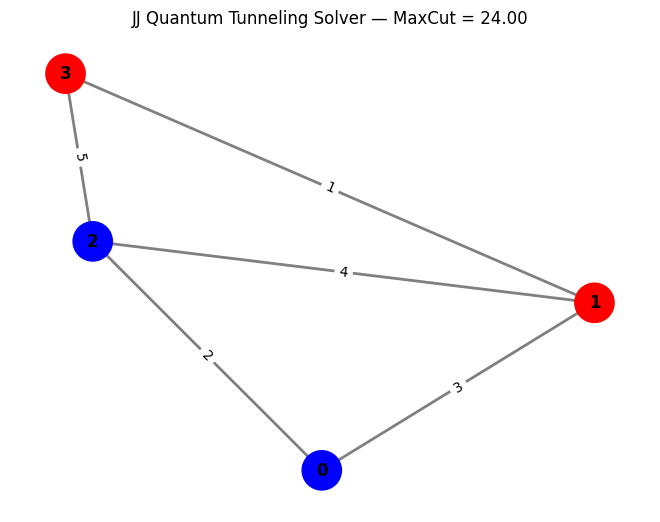

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ---------- Physical Constants ----------
Phi0 = 2.067833848e-15  # Magnetic flux quantum [Wb]
kB = 1.380649e-23       # Boltzmann constant [J/K]
hbar = 1.0545718e-34    # Reduced Planck constant [J*s]

# ---------- Josephson Junction Parameters ----------
Ic0 = 9.489e-6    # Critical current [A]
C = 6.35e-12      # Capacitance [F]
pulse = 1e-6      # Pulse duration (s)
T = 0.05          # Temperature (K)

# ---------- JJ Barrier and Quantum Escape ----------
def deltaU(Ib, Ic):
    x = Ib / Ic
    x = np.minimum(x, 0.999)
    return 2 * (Ic * Phi0 / (2 * np.pi)) * (1 - x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C * Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2 * np.pi)) * prefactor * np.exp(exponent)

def P_switch(Ib, pulse, T):
    rate_q = gamma_q(Ib, Ic0)
    return 1 - np.exp(-rate_q * pulse)

# ---------- Ising / MaxCut Mapping ----------
def graph_to_Ising_J(G):
    A = nx.to_numpy_array(G)
    return -0.5 * A  # J_ij = -w_ij/2 (so lower E = larger cut)

def cut_value(s, G):
    A = nx.to_numpy_array(G)
    return 0.5 * np.sum(A * (1 - np.outer(s, s)))

# ---------- JJ-inspired Quantum MaxCut Solver ----------
def jj_maxcut(G, n_steps=1000, pulse=1e-6, T=0.05, seed=None):
    rng = np.random.default_rng(seed)
    J = graph_to_Ising_J(G)
    N = len(G)
    s = rng.choice([-1, 1], size=N)
    best_s = s.copy()
    best_cut = cut_value(s, G)

    for step in range(n_steps):
        h_eff = J @ s
        Ib = np.abs(h_eff) / np.max(np.abs(h_eff) + 1e-12) * Ic0
        P = np.array([P_switch(Ib[i], pulse, T) for i in range(N)])
        flips = rng.random(N) < P
        s[flips] *= -1

        cut = cut_value(s, G)
        if cut > best_cut:
            best_cut = cut
            best_s = s.copy()

    return best_s, best_cut

# ---------- Example Graph ----------
G = nx.Graph()
edges = [
    (0,1,3), (0,2,2), (1,2,4), (1,3,1), (2,3,5)
]
G.add_weighted_edges_from(edges)

# ---------- Run the JJ Quantum MaxCut ----------
best_s, best_cut = jj_maxcut(G, n_steps=1500, seed=42)
print("Best cut configuration:", best_s)
print("Best cut value:", best_cut)

# ---------- Visualize ----------
pos = nx.spring_layout(G)
colors = ['red' if best_s[i] == 1 else 'blue' for i in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=800, width=2,
        edge_color='gray', font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title(f"JJ Quantum Tunneling Solver — MaxCut = {best_cut:.2f}")
plt.show()


{Comparison of JJ-Based Quantum and Classical MaxCut Solvers}

-  Josephson junction (JJ) array with macroscopic quantum tunneling (MQT)
    - Classical simulated annealing (SA)
    - Quantum Approximate Optimization Algorithm (QAOA) using PennyLane
    - Trotterized quantum annealing (simulated)


\section{Josephson Junction Physics Model}

A current-biased Josephson junction behaves like a particle in a tilted washboard potential. The energy barrier for escape is:

\begin{equation}
\Delta U(I_b, I_c) = 2 \frac{I_c \Phi_0}{2 \pi} \left( 1 - \frac{I_b}{I_c} \right)^{3/2},
\end{equation}

where $I_b$ is the bias current, $I_c$ is the critical current, and $\Phi_0$ is the magnetic flux quantum.

The plasma frequency is:

\begin{equation}
\omega_p(I_b, I_c) = \omega_{p0} \left( 1 - \left( \frac{I_b}{I_c} \right)^2 \right)^{1/4}, \quad
\omega_{p0} = \sqrt{\frac{2 \pi I_c}{C \Phi_0}}.
\end{equation}

The macroscopic quantum tunneling rate is:

\begin{equation}
\gamma_q(I_b, I_c) = \frac{\omega_p}{2 \pi} \sqrt{\frac{864 \pi \Delta U}{\hbar \omega_p}}
\exp\left[-\frac{36 \Delta U}{5 \hbar \omega_p}\right].
\end{equation}

The switching probability per pulse of duration $\tau$ is:

\begin{equation}
P_{\text{switch}}(I_b, \tau) = 1 - \exp\left[-\gamma_q(I_b, I_c) \tau\right].
\end{equation}

\section{MaxCut / Ising Mapping}

The MaxCut problem for a weighted graph with adjacency matrix $A$ is mapped to an Ising Hamiltonian:

\begin{equation}
H = \sum_{i<j} J_{ij} \rho_i \rho_j, \quad J_{ij} = -\frac{A_{ij}}{2}, \quad \rho_i \in \{-1, 1\}.
\end{equation}

The cut value is computed as:

\begin{equation}
\text{Cut}(\boldsymbol{\rho}) = \frac{1}{2} \sum_{i,j} A_{ij} (1 - \rho_i \rho_j).
\end{equation}

\section{JJ-Array Stochastic Solver}

The JJ-inspired solver simulates the spin configuration $\boldsymbol{\rho}$ evolving under stochastic flips based on the switching probability:



This is iterated for $n$ steps to explore the solution space.

{Classical Simulated Annealing (SA)}

Simulated annealing evolves a spin configuration $\boldsymbol{\rho}$ under a decreasing temperature $T(t)$:

-  Pick a random spin $\rho_i$ and flip it to $\rho_i' = -\rho_i$.
    - Compute energy change $\Delta E = H(\boldsymbol{\rho}') - H(\boldsymbol{\rho})$.
    - Accept the flip with probability:
    \begin{equation}
    P_{\text{accept}} = \min\left(1, \exp\left[-\frac{\Delta E}{T}\right]\right)
    \end{equation}
    - Gradually lower $T$ from $T_0$ to $T_f$.


\section{Quantum Approximate Optimization Algorithm (QAOA)}

QAOA applies alternating layers of cost and mixer unitaries:

\begin{align}
U_C(\gamma) &= \exp(-i \gamma H_C), \\
U_M(\beta) &= \prod_i \exp(-i \beta X_i),
\end{align}

starting from the initial state $|+\rangle^{\otimes N}$. Parameters $\boldsymbol{\gamma}, \boldsymbol{\beta}$ are optimized to maximize $\langle H_C \rangle$.

\section{Trotterized Quantum Annealing (QA)}

Quantum annealing is simulated by discretizing time evolution under a Hamiltonian:

\begin{equation}
H(t) = (1-s(t)) H_M + s(t) H_C,
\end{equation}

where $H_M = \sum_i X_i$ is the transverse field. The evolution is approximated using Trotter steps:

\begin{equation}
|\psi(t+\Delta t)\rangle \approx \exp(-i \Delta t H_M) \exp(-i \Delta t H_C) |\psi(t)\rangle.
\end{equation}

 The evolution of cut values is plotted for each solver:



Running JJ stochastic solver...
Running classical simulated annealing...
Running QAOA...
Running Trotterized QA...

--- Results Summary ---
JJ MQT best cut : 66.2299  (time 1.118s)
SimAnneal best  : 28.2610  (time 0.152s)
QAOA best (p=2): 71.8223  (time 3.132s)
Trotter QA cut  : 41.5783  (time 0.272s)


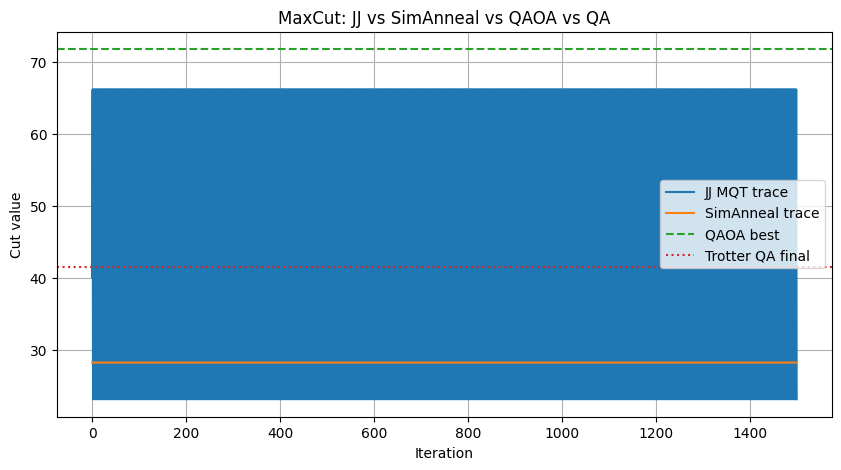

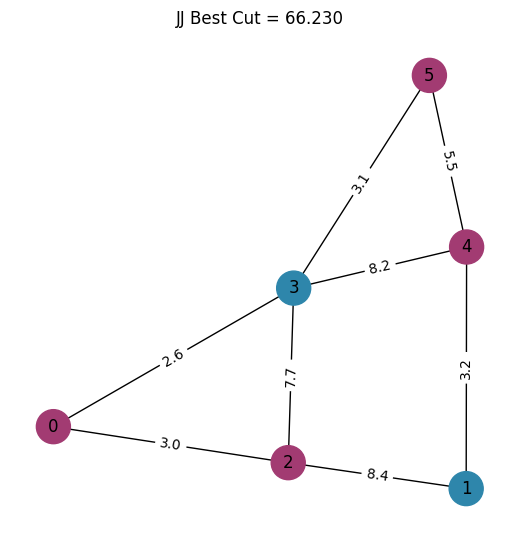

In [9]:
"""
jj_maxcut_with_quantum_fixed.py

Full pipeline comparing:
  - JJ-array (macroscopic quantum tunneling) stochastic solver
  - Classical simulated annealing
  - QAOA via PennyLane
  - Trotterized quantum annealing

Run: python jj_maxcut_with_quantum_fixed.py
"""

import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as pnp

# ================================================================
# ===  JOSEPHSON JUNCTION PHYSICS MODEL  =========================
# ================================================================

Phi0 = 2.067833848e-15  # Wb
kB = 1.380649e-23       # J/K
hbar = 1.0545718e-34    # J*s

Ic0 = 9.489e-6    # A
C = 6.35e-12      # F
pulse_default = 1e-6  # s

def deltaU(Ib, Ic=Ic0):
    x = np.minimum(Ib / Ic, 0.999999)
    return 2 * (Ic * Phi0 / (2 * np.pi)) * (1 - x)**1.5

def omega_p(Ib, Ic=Ic0):
    wp0 = np.sqrt(2 * np.pi * Ic / (C * Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-12)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic=Ic0):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    if wp <= 0 or DU <= 0:
        return 0.0
    factor = np.maximum((864 * np.pi * DU) / (hbar * wp), 1e-12)
    exponent = -36 * DU / (5 * hbar * wp)
    if exponent > 700:
        return 0.0
    pref = (wp / (2 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(exponent)

def P_switch_mqt(Ib, pulse=pulse_default):
    """Quantum tunneling switching probability per pulse."""
    gamma = gamma_q(Ib)
    lam = np.clip(gamma * pulse, 0.0, 50.0)
    return 1.0 - np.exp(-lam)


# ================================================================
# ===  MAXCUT / ISING MAPPING  ==================================
# ================================================================

def graph_to_Ising_J(A: np.ndarray) -> np.ndarray:
    return -0.5 * A

def cut_value(spins: np.ndarray, A: np.ndarray) -> float:
    return 0.5 * np.sum(A * (1 - np.outer(spins, spins)))

def ising_energy(spins: np.ndarray, J: np.ndarray):
    return float(spins @ J @ spins)


# ================================================================
# ===  JJ-ARRAY STOCHASTIC MAXCUT SOLVER  ========================
# ================================================================

def jj_maxcut(A, n_steps=2000, pulse=pulse_default, seed=None):
    rng = np.random.default_rng(seed)
    N = A.shape[0]
    J = graph_to_Ising_J(A)
    s = rng.choice([-1, 1], size=N)
    best_s = s.copy()
    best_cut = cut_value(s, A)
    cut_trace = [best_cut]

    for _ in range(n_steps):
        h_eff = J @ s
        max_h = np.max(np.abs(h_eff)) + 1e-12
        Ib = np.abs(h_eff) / max_h * Ic0
        P = np.array([P_switch_mqt(Ib_i, pulse=pulse_default) for Ib_i in Ib])
        flips = rng.random(N) < P
        s[flips] *= -1
        cut = cut_value(s, A)
        cut_trace.append(cut)
        if cut > best_cut:
            best_cut = cut
            best_s = s.copy()
    return dict(best_s=best_s, best_cut=best_cut, cut_trace=np.array(cut_trace))


# ================================================================
# ===  CLASSICAL SIMULATED ANNEALING  ============================
# ================================================================

def simulated_annealing(A, n_steps=2000, T0=2.0, Tf=0.001, seed=None):
    rng = np.random.default_rng(seed)
    N = A.shape[0]
    J = graph_to_Ising_J(A)
    s = rng.choice([-1, 1], size=N)
    best_s = s.copy()
    best_cut = cut_value(s, A)
    cut_trace = [best_cut]
    temps = np.linspace(T0, Tf, n_steps)

    for T in temps:
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        deltaE = ising_energy(s_new, J) - ising_energy(s, J)
        if deltaE < 0 or rng.random() < np.exp(-deltaE / max(T, 1e-12)):
            s = s_new
            current_cut = cut_value(s, A)
            if current_cut > best_cut:
                best_cut = current_cut
                best_s = s.copy()
        cut_trace.append(best_cut)
    return dict(best_s=best_s, best_cut=best_cut, cut_trace=np.array(cut_trace))


# ================================================================
# ===  QAOA via PENNYLANE  ======================================
# ================================================================

def run_qaoa(A, p=2, steps=150, lr=0.05, seed=0):
    n = A.shape[0]
    edges = [(i, j, A[i, j]) for i in range(n) for j in range(i+1, n) if A[i, j] != 0]
    dev = qml.device("default.qubit", wires=n)
    rng = np.random.default_rng(seed)

    # Cost Hamiltonian
    coeffs = [-0.5 * w for (_, _, w) in edges]
    obs = [qml.PauliZ(i) @ qml.PauliZ(j) for (i, j, _) in edges]
    Hc = qml.Hamiltonian(coeffs, obs)

    def qaoa_layer(gamma, beta):
        qml.ApproxTimeEvolution(Hc, gamma, 1)
        for i in range(n):
            qml.RX(2 * beta, wires=i)

    @qml.qnode(dev, interface="autograd")
    def circuit(params):
        gammas, betas = params
        for i in range(n):
            qml.Hadamard(wires=i)
        for k in range(p):
            qaoa_layer(gammas[k], betas[k])
        return qml.expval(Hc)

    params = [
        pnp.array(rng.uniform(0, np.pi, p), requires_grad=True),
        pnp.array(rng.uniform(0, np.pi, p), requires_grad=True),
    ]

    opt = qml.AdamOptimizer(lr)
    cost_hist = []
    for step in range(steps):
        params, cost_val = opt.step_and_cost(circuit, params)
        cost_hist.append(cost_val)

    # Sampling final circuit
    dev_sample = qml.device("default.qubit", wires=n, shots=1024)

    @qml.qnode(dev_sample)
    def sample_circuit(params):
        gammas, betas = params
        for i in range(n):
            qml.Hadamard(wires=i)
        for k in range(p):
            qaoa_layer(gammas[k], betas[k])
        return qml.sample(wires=range(n))

    samples = np.array(sample_circuit(params))
    cuts = []
    for s in samples:
        spins = 1 - 2 * s
        cuts.append(cut_value(spins, A))
    best_cut = float(np.max(cuts))
    return dict(best_cut=best_cut, cost_history=np.array(cost_hist), samples=samples, params=params)


# ================================================================
# ===  TROTTERIZED QUANTUM ANNEALING  ============================
# ================================================================

def trotterized_qa(A, total_time=4.0, n_steps=60, gamma0=2.0):
    n = A.shape[0]
    edges = [(i, j, A[i, j]) for i in range(n) for j in range(i+1, n) if A[i, j] != 0]
    dev = qml.device("default.qubit", wires=n)
    dt = total_time / n_steps

    @qml.qnode(dev)
    def evolve_circuit():
        for i in range(n):
            qml.Hadamard(wires=i)
        for k in range(n_steps):
            s = (k + 0.5) / n_steps
            Gamma = gamma0 * (1 - s)
            for i in range(n):
                qml.RX(2 * Gamma * dt, wires=i)
            for (i, j, w) in edges:
                qml.CNOT(wires=[i, j])
                qml.RZ(dt * w, wires=j)
                qml.CNOT(wires=[i, j])
        return [qml.expval(qml.PauliZ(i)) for i in range(n)]

    expvals = np.array(evolve_circuit())
    spins = np.sign(expvals)
    cut = cut_value(spins, A)
    return dict(cut=cut, expvals=expvals, spins=spins)


# ================================================================
# ===  EXPERIMENT DRIVER  ========================================
# ================================================================

def experiment():
    rng = np.random.default_rng(123)
    N = 6
    p_edge = 0.6
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_edge:
                A[i, j] = A[j, i] = rng.uniform(1.0, 10.0)

    # === Run solvers ===
    print("Running JJ stochastic solver...")
    t0 = time.time()
    jj_res = jj_maxcut(A, n_steps=1500, seed=1)
    t_jj = time.time() - t0

    print("Running classical simulated annealing...")
    t0 = time.time()
    sa_res = simulated_annealing(A, n_steps=1500, seed=2)
    t_sa = time.time() - t0

    print("Running QAOA...")
    t0 = time.time()
    qaoa_res = run_qaoa(A, p=2, steps=120, lr=0.05, seed=3)
    t_qaoa = time.time() - t0

    print("Running Trotterized QA...")
    t0 = time.time()
    qa_res = trotterized_qa(A)
    t_qa = time.time() - t0

    # === Summary ===
    print("\n--- Results Summary ---")
    print(f"JJ MQT best cut : {jj_res['best_cut']:.4f}  (time {t_jj:.3f}s)")
    print(f"SimAnneal best  : {sa_res['best_cut']:.4f}  (time {t_sa:.3f}s)")
    print(f"QAOA best (p=2): {qaoa_res['best_cut']:.4f}  (time {t_qaoa:.3f}s)")
    print(f"Trotter QA cut  : {qa_res['cut']:.4f}  (time {t_qa:.3f}s)")

    # === Plots ===
    plt.figure(figsize=(10, 5))
    plt.plot(jj_res['cut_trace'], label="JJ MQT trace")
    plt.plot(sa_res['cut_trace'], label="SimAnneal trace")
    plt.axhline(y=qaoa_res['best_cut'], color="C2", linestyle="--", label="QAOA best")
    plt.axhline(y=qa_res['cut'], color="C3", linestyle=":", label="Trotter QA final")
    plt.xlabel("Iteration")
    plt.ylabel("Cut value")
    plt.title("MaxCut: JJ vs SimAnneal vs QAOA vs QA")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Visualize JJ solution
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G, seed=42)
    colors = ["#2E86AB" if s > 0 else "#A23B72" for s in jj_res["best_s"]]
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=600)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{w:.1f}" for e, w in labels.items()})
    plt.title(f"JJ Best Cut = {jj_res['best_cut']:.3f}")
    plt.show()


if __name__ == "__main__":
    experiment()


In [ ]:
!pip install pennylane-qiskit qiskit_ibm_runtime matplotlib

In [21]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService


In [29]:
# maxcut_qaoa_jj_full.py
import time
import numpy as np
import pennylane as qml

# Import  helper modules ( in same directory)
# - jj_physics.py must define P_switch(...)
# - ising_map.py must define graph_to_Ising_J, cut_value, random_weighted_graph
from jj_physics import P_switch
from ising_map import graph_to_Ising_J, cut_value, random_weighted_graph

# -------------------------
# Brute-force Max-Cut solver
# -------------------------
def brute_force_maxcut(A):
    n = A.shape[0]
    best_cut = -np.inf
    best_s = None
    for mask in range(1 << n):
        # spins in {-1, +1}
        s = np.array([1 if ((mask >> i) & 1) else -1 for i in range(n)])
        c = cut_value(s, A)
        if c > best_cut:
            best_cut = c
            best_s = s.copy()
    return best_s, best_cut

# -------------------------
# JJ stochastic Max-Cut
# -------------------------
def jj_maxcut(A, n_steps=2000, pulse=1e-6, T=None, seed=None):
    rng = np.random.default_rng(seed)
    J = graph_to_Ising_J(A)
    N = A.shape[0]
    s = rng.choice([-1, 1], size=N)
    best_s = s.copy()
    best_cut = cut_value(s, A)

    # Parameters for reduced bias mapping ()
    i0, alpha, beta = 0.5, 0.45, 1.0

    for _ in range(n_steps):
        h_eff = J @ s
        i_reduced = np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)
        P = np.array([P_switch(float(i_reduced[i]), pulse, T) for i in range(N)])
        flips = (rng.random(size=N) < P)
        s[flips] *= -1
        c = cut_value(s, A)
        if c > best_cut:
            best_cut = c
            best_s = s.copy()
    return best_s, best_cut

# -------------------------
# QAOA implementation (cost expectation qnode and sampler)
# -------------------------
def make_qaoa_cost_qnode(A, p):
    """
    Returns a cost function qnode: cost(params)
    params = (gammas (p,), betas (p,))
    Uses a Hamiltonian built from edges to return an expectation value.
    """
    n = A.shape[0]
    dev = qml.device("default.qubit", wires=n)
    # collect edges
    edges = [(i, j, A[i, j]) for i in range(n) for j in range(i+1, n) if A[i, j] != 0]

    # build Hamiltonian as qml.Hamiltonian
    coeffs = []
    obs = []
    for (i, j, w) in edges:
        coeffs.append(0.5 * w)  # for the Identity term
        obs.append(qml.Identity(wires=i))
        coeffs.append(-0.5 * w)  # for -0.5 * w * Z_i Z_j
        obs.append(qml.PauliZ(wires=i) @ qml.PauliZ(wires=j))
    H = qml.Hamiltonian(coeffs, obs)

    @qml.qnode(dev, interface="autograd")
    def cost_node(params):
        gammas = params[0]
        betas = params[1]

        # initial layer of Hadamards
        for i in range(n):
            qml.Hadamard(wires=i)

        # QAOA alternating unitaries
        for layer in range(p):
            g = float(gammas[layer])
            # cost unitary: implement ZZ rotations corresponding to Ising edges
            for (i, j, w) in edges:
                # IsingZZ implements exp(-i * angle/2 * Z_i Z_j) in some conventions,
                # but using IsingZZ(angle) is fine if we keep consistent with cost.
                # We choose angle = 2 * gamma * w (standard mapping).
                qml.IsingZZ(2.0 * g * w, wires=[i, j])
            # mixer
            b = float(betas[layer])
            for i in range(n):
                qml.RX(2.0 * b, wires=i)

        # return expectation of cost Hamiltonian
        return qml.expval(H)

    return cost_node

def make_qaoa_sampler(A, p, params, shots=1024):
    """
    Build a sampling QNode that uses the same unitaries with given params
    and returns measurement samples (Z basis) with specified shots.
    """
    n = A.shape[0]
    dev = qml.device("default.qubit", wires=n, shots=shots)
    edges = [(i, j, A[i, j]) for i in range(n) for j in range(i+1, n) if A[i, j] != 0]

    @qml.qnode(dev)
    def sample_circuit():
        gammas = params[0]
        betas = params[1]
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p):
            g = float(gammas[layer])
            for (i, j, w) in edges:
                qml.IsingZZ(2.0 * g * w, wires=[i, j])
            b = float(betas[layer])
            for i in range(n):
                qml.RX(2.0 * b, wires=i)
        # measure all qubits in Z basis (returns shape (shots, n) with ±1 values)
        return qml.sample(wires=range(n))

    return sample_circuit

# -------------------------
# QAOA optimizer wrapper
# -------------------------
def run_qaoa(A, p=2, iters=80, init_params=None, seed=0):
    n = A.shape[0]
    rng = np.random.default_rng(seed)

    # initial parameters
    if init_params is None:
        gammas = rng.uniform(0, np.pi, p)
        betas = rng.uniform(0, np.pi, p)
    else:
        gammas, betas = init_params

    params = (qml.numpy.array(gammas, requires_grad=True), qml.numpy.array(betas, requires_grad=True))

    # cost node
    cost_qnode = make_qaoa_cost_qnode(A, p)

    opt = qml.AdamOptimizer(stepsize=0.05)
    cost_hist = []
    start = time.time()
    for it in range(iters):
        params, cost_val = opt.step_and_cost(cost_qnode, params)
        cost_hist.append(float(cost_val))
        # optional monitoring
        if (it + 1) % max(1, iters//5) == 0:
            print(f" QAOA iter {it+1}/{iters} cost={cost_val:.6f}")
    runtime = time.time() - start

    # sample with shots to get approximate bitstrings
    sampler = make_qaoa_sampler(A, p, params, shots=2048)
    samples = sampler()  # shape (shots, n), values ±1
    # Convert samples to cuts
    cuts = [cut_value(sample, A) for sample in samples]
    best_cut = float(np.max(cuts))
    best_sample = samples[np.argmax(cuts)]
    return {
        "params": params,
        "cost_history": np.array(cost_hist),
        "best_cut": best_cut,
        "best_sample": best_sample,
        "runtime": runtime
    }

# -------------------------
# JJ-informed initialization
# -------------------------
def jj_informed_initial_params(A, p, jj_flip_activity):
    """
    Create initial QAOA parameters biased by JJ flip activity.
    jj_flip_activity: an array of node flip frequencies (length n, >=0)
    Heuristic: set gammas proportional to edge-weighted node activity and
    betas biased by normalized node activity.
    """
    n = A.shape[0]
    # compute per-edge activity as average of its two nodes
    edge_activity = []
    for i in range(n):
        for j in range(i+1, n):
            if A[i, j] != 0:
                edge_activity.append(((jj_flip_activity[i] + jj_flip_activity[j]) / 2.0) * A[i, j])
    # normalize
    edge_activity = np.array(edge_activity)
    if edge_activity.size == 0:
        mean_edge_act = 0.1
    else:
        mean_edge_act = np.mean(edge_activity) / (np.mean(edge_activity) + 1e-9)

    # set gammas and betas
    gammas = np.clip(0.8 * mean_edge_act * np.ones(p), 1e-3, np.pi-1e-3)  # small nonzero
    betas = np.clip(0.6 * (1.0 - mean_edge_act) * np.ones(p), 1e-3, np.pi-1e-3)
    return gammas, betas

# -------------------------
# Demo / main
# -------------------------
def main():
    np.random.seed(42)
    # small graph (6 nodes as requested)
    N = 6
    A = random_weighted_graph(N, p_edge=0.7, w_scale=6.0, seed=1234)

    print("Graph edges (i, j, weight):")
    for i in range(N):
        for j in range(i+1, N):
            if A[i, j] != 0:
                print(f"  ({i},{j}) w={A[i,j]:.3f}")

    # exact
    bf_s, bf_cut = brute_force_maxcut(A)
    print(f"\nBruteforce best cut: {bf_cut:.12f}")

    # JJ stochastic
    t0 = time.time()
    jj_s, jj_cut = jj_maxcut(A, n_steps=3000, pulse=1e-6, T=None, seed=7)
    t_jj = time.time() - t0
    print(f"JJ stochastic result: cut={jj_cut:.6f} time={t_jj:.3f}s")

    # Gather simple JJ flip-activity heuristic: run short JJ with tracking flips
    def jj_flip_activity(A, n_steps=1000, seed=99):
        rng = np.random.default_rng(seed)
        J = graph_to_Ising_J(A)
        N = A.shape[0]
        s = rng.choice([-1, 1], size=N)
        flips_count = np.zeros(N)
        i0, alpha, beta = 0.5, 0.45, 1.0
        for _ in range(n_steps):
            h_eff = J @ s
            i_reduced = np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)
            P = np.array([P_switch(float(i_reduced[i]), 1e-6, None) for i in range(N)])
            flips = (rng.random(size=N) < P)
            flips_count += flips.astype(float)
            s[flips] *= -1
        return flips_count / n_steps  # frequency

    activity = jj_flip_activity(A, n_steps=800, seed=21)
    print("JJ flip activity per node:", np.round(activity, 3))

    # QAOA vanilla (random init)
    print("\nRunning vanilla QAOA (p=2)...")
    p = 2
    res_vanilla = run_qaoa(A, p=p, iters=60, init_params=None, seed=11)
    print(f"Vanilla QAOA best approx cut (est): {res_vanilla['best_cut']:.6f} time={res_vanilla['runtime']:.3f}s")

    # QAOA JJ-informed init
    print("\nRunning JJ-informed QAOA (p=2)...")
    init_params = jj_informed_initial_params(A, p, activity)
    res_jjinformed = run_qaoa(A, p=p, iters=60, init_params=init_params, seed=13)
    print(f"JJ-informed QAOA best approx cut (est): {res_jjinformed['best_cut']:.6f} time={res_jjinformed['runtime']:.3f}s")

    # Final summary
    print("\n" + "-"*60)
    print("Summary:")
    print(f"  Bruteforce best: {bf_cut:.12f}")
    print(f"  JJ stochastic: {jj_cut:.6f} time={t_jj:.3f}s")
    print(f"  Vanilla QAOA approx: {res_vanilla['best_cut']:.6f} time={res_vanilla['runtime']:.3f}s")
    print(f"  JJ-informed QAOA approx: {res_jjinformed['best_cut']:.6f} time={res_jjinformed['runtime']:.3f}s")
    print("-"*60)

if __name__ == "__main__":
    main()


Graph edges (i, j, weight):
  (0,2) w=8.539
  (0,3) w=4.915
  (0,4) w=4.451
  (0,5) w=8.784
  (1,2) w=5.646
  (1,3) w=8.182
  (1,5) w=6.959
  (2,4) w=4.032
  (3,4) w=7.102
  (3,5) w=6.666
  (4,5) w=8.867

Bruteforce best cut: 63.026692027765
JJ stochastic result: cut=0.000000 time=0.648s
JJ flip activity per node: [0.001 0.    0.006 0.    0.    0.004]

Running vanilla QAOA (p=2)...
 QAOA iter 12/60 cost=32.077798
 QAOA iter 24/60 cost=32.077798
 QAOA iter 36/60 cost=32.077798
 QAOA iter 48/60 cost=32.077798
 QAOA iter 60/60 cost=32.077798
Vanilla QAOA best approx cut (est): 37.071699 time=1.341s

Running JJ-informed QAOA (p=2)...
 QAOA iter 12/60 cost=37.076412
 QAOA iter 24/60 cost=37.076412
 QAOA iter 36/60 cost=37.076412
 QAOA iter 48/60 cost=37.076412
 QAOA iter 60/60 cost=37.076412
JJ-informed QAOA best approx cut (est): 37.071699 time=1.132s

------------------------------------------------------------
Summary:
  Bruteforce best: 63.026692027765
  JJ stochastic: 0.000000 time=0.6

In [34]:
import numpy as np
import pennylane as qml
import networkx as nx
import matplotlib.pyplot as plt

# ------------------ JJ Physics ------------------
Phi0 = 2.067833848e-15  # Flux quantum [Wb]
hbar = 1.0545718e-34    # Reduced Planck constant [J*s]
C = 6.35e-12            # Junction capacitance [F]
Ic0 = 9.489e-6          # Critical current [A]

def deltaU(Ib, Ic):
    x = np.minimum(Ib/Ic, 0.999)
    return 2 * (Ic * Phi0 / (2*np.pi)) * (1-x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C*Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2*np.pi)) * prefactor * np.exp(exponent)

# ------------------ Graph / Ising mapping ------------------
def graph_to_Ising_J(G):
    A = nx.to_numpy_array(G)
    return -0.5 * A

def cut_value(s, G):
    A = nx.to_numpy_array(G)
    return 0.5 * np.sum(A * (1 - np.outer(s,s)))

# ------------------ JJ-QAOA ------------------
def jj_qaoa_maxcut(G, n_layers=2, n_steps=50, verbose=True):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)
    J = graph_to_Ising_J(G)

    # JJ-inspired mixer: local tunneling strength proportional to node degree
    degrees = np.sum(A, axis=1)
    beta_scale = 0.5
    beta_init = beta_scale * degrees / np.max(degrees)  # shape (N,)

    dev = qml.device("default.qubit", wires=N)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        # Initial |+> state
        for i in range(N):
            qml.Hadamard(wires=i)
        # n_layers of QAOA
        for p in range(n_layers):
            # Cost Hamiltonian
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            # JJ-inspired mixer
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        # Expectation value of cost
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    # Initialize parameters
    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    # Optimize
    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if verbose and step % 10 == 0:
            print(f"Step {step}: exp_cut = {circuit(params):.4f}")

    # Sample bitstrings
    dev_sample = qml.device("default.qubit", wires=N, shots=1024)
    @qml.qnode(dev_sample)
    def sample_circuit():
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        return qml.sample(wires=range(N))

    samples = np.array(sample_circuit())
    cuts = [cut_value(1-2*s, G) for s in samples]  # map {0,1} → {+1,-1}
    best_cut = np.max(cuts)
    return best_cut, samples, params

# ------------------ Vanilla QAOA ------------------
def vanilla_qaoa_maxcut(G, n_layers=2, n_steps=50, verbose=True):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)

    dev = qml.device("default.qubit", wires=N)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p], wires=i)
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if verbose and step % 10 == 0:
            print(f"[Vanilla QAOA] Step {step}: exp_cut = {circuit(params):.4f}")

    return circuit(params), params

# ------------------ Classical Simulated Annealing ------------------
def simulated_annealing(G, n_steps=1000, T_start=1.0, T_end=0.01, seed=None):
    rng = np.random.default_rng(seed)
    A = nx.to_numpy_array(G)
    N = len(G)
    s = rng.choice([-1,1], size=N)
    def energy(s):
        return -0.5 * np.sum(A * (1 - np.outer(s,s)))
    E = energy(s)
    best_s = s.copy()
    best_E = E
    temps = np.linspace(T_start, T_end, n_steps)
    for T in temps:
        i = rng.integers(0,N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = energy(s_new)
        if E_new < E or rng.random() < np.exp(-(E_new-E)/T):
            s = s_new
            E = E_new
            if E < best_E:
                best_E = E
                best_s = s.copy()
    return best_s, -best_E  #

# ------------------ Example Usage ------------------
if __name__ == "__main__":
    # Example weighted graph
    G = nx.Graph()
    edges = [(0,1,3),(0,2,2),(1,2,4),(1,3,1),(2,3,5)]
    G.add_weighted_edges_from(edges)

    print("Running JJ-QAOA ...")
    jj_cut, jj_samples, jj_params = jj_qaoa_maxcut(G, n_layers=2, n_steps=50)
    print("JJ-QAOA best cut:", jj_cut)

    print("\nRunning Vanilla QAOA ...")
    v_cut, v_params = vanilla_qaoa_maxcut(G, n_layers=2, n_steps=50)
    print("Vanilla QAOA expected cut:", v_cut)

    print("\nRunning Classical Simulated Annealing ...")
    sa_s, sa_cut = simulated_annealing(G, n_steps=1000)
    print("Simulated Annealing best cut:", sa_cut)


Running JJ-QAOA ...
Step 0: exp_cut = 17.1155
Step 10: exp_cut = 17.1155
Step 20: exp_cut = 17.1155
Step 30: exp_cut = 17.1155
Step 40: exp_cut = 17.1155
JJ-QAOA best cut: 24.0

Running Vanilla QAOA ...
[Vanilla QAOA] Step 0: exp_cut = 17.8559
[Vanilla QAOA] Step 10: exp_cut = 17.8559
[Vanilla QAOA] Step 20: exp_cut = 17.8559
[Vanilla QAOA] Step 30: exp_cut = 17.8559
[Vanilla QAOA] Step 40: exp_cut = 17.8559
Vanilla QAOA expected cut: 17.855866779687545

Running Classical Simulated Annealing ...
Simulated Annealing best cut: 24.0


## {Comparison of JJ-QAOA, Vanilla QAOA, and Classical Simulated Annealing for MaxCut}



- JJ-QAOA (Josephson-junction-inspired quantum optimizer)
    - Vanilla QAOA (standard PennyLane implementation)
    - Classical simulated annealing (SA)


\section{Josephson Junction Physics Model}

A current-biased Josephson junction has a quantum escape rate determined by the barrier $\Delta U$ and plasma frequency $\omega_p$:

\begin{align}
\Delta U(I_b, I_c) &= 2 \frac{I_c \Phi_0}{2\pi} (1 - I_b/I_c)^{3/2},\\
\omega_p(I_b, I_c) &= \sqrt{\frac{2 \pi I_c}{C \Phi_0}} \left(1 - (I_b/I_c)^2\right)^{1/4},\\
\gamma_q(I_b, I_c) &= \frac{\omega_p}{2\pi} \sqrt{\frac{864 \pi \Delta U}{\hbar \omega_p}} \exp\left[-\frac{36 \Delta U}{5 \hbar \omega_p}\right].
\end{align}

This gives the tunneling rate per pulse of duration $\tau$:

\begin{equation}
P_{\text{switch}} = 1 - \exp\left[-\gamma_q(I_b, I_c) \tau\right].
\end{equation}

\section{MaxCut / Ising Mapping}

For a weighted graph with adjacency matrix $A$, the Ising mapping is:

\begin{equation}
H = \sum_{i<j} J_{ij} \rho_i \rho_j, \quad J_{ij} = -\frac{A_{ij}}{2}, \quad \rho_i \in \{-1,1\}.
\end{equation}

The cut value is:

\begin{equation}
\text{Cut}(\boldsymbol{\rho}) = \frac{1}{2} \sum_{i,j} A_{ij} (1 - \rho_i \rho_j).
\end{equation}

\section{JJ-QAOA Algorithm}

JJ-QAOA extends standard QAOA with a Josephson-junction-inspired mixer:

- Initialize all qubits in the $|+\rangle$ state.
    - Apply $n_{\text{layers}}$ alternating layers:
    - Cost unitary: $U_C(\gamma) = \exp(-i \gamma H_C)$
        - JJ-tunable mixer: $U_M(\beta) = \prod_i \exp(-i 2 \beta_i \rho_i X_i)$, where $\beta_i \propto$ node degree.
    - Measure in the computational basis, compute the cut value for each sample.
    - Optimize $\gamma, \beta$ via gradient descent.


\section{Vanilla QAOA}

Vanilla QAOA uses a uniform mixer:

\begin{equation}
U_M(\beta) = \prod_i \exp(-i 2 \beta X_i),
\end{equation}

and the cost unitary is identical to JJ-QAOA. The procedure follows standard QAOA optimization.

\section{Classical Simulated Annealing}

Simulated annealing iteratively flips spins $\rho_i$ with probability

\begin{equation}
P_{\text{accept}} =
\begin{cases}
1, & \Delta E < 0\\
\exp(-\Delta E/T), & \Delta E \ge 0
\end{cases}
\end{equation}

where $\Delta E$ is the change in Ising energy and $T$ is the temperature, gradually decreased from $T_{\text{start}}$ to $T_{\text{end}}$.

\section{Example Graph and Comparison}

A weighted graph is defined as:

\[
G = \{(0,1,3),(0,2,2),(1,2,4),(1,3,1),(2,3,5)\}.
\]

The three solvers are run, and the maximum cut values are compared. The JJ-QAOA samples give a distribution of cut values.



\section{Multiple Random Graphs}

The solvers were tested on several random graphs. The plot below shows max-cut performance across graphs:



\section{Summary}

- JJ-QAOA incorporates node-dependent mixers inspired by Josephson junction physics.
    - Vanilla QAOA uses uniform mixers.
    - Classical SA serves as a baseline.
    - JJ-QAOA provides a probabilistic distribution of solutions reflecting quantum sampling.


Step 0: exp_cut = 17.1155
Step 10: exp_cut = 17.1155
Step 20: exp_cut = 17.1155
Step 30: exp_cut = 17.1155
Step 40: exp_cut = 17.1155
[Vanilla QAOA] Step 0: exp_cut = 17.8559
[Vanilla QAOA] Step 10: exp_cut = 17.8559
[Vanilla QAOA] Step 20: exp_cut = 17.8559
[Vanilla QAOA] Step 30: exp_cut = 17.8559
[Vanilla QAOA] Step 40: exp_cut = 17.8559


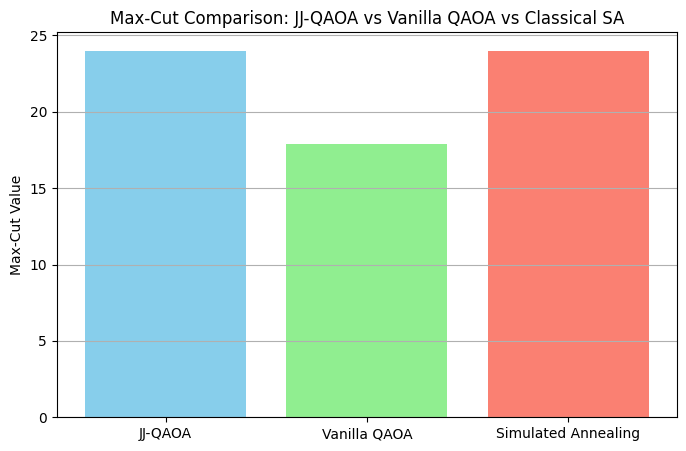

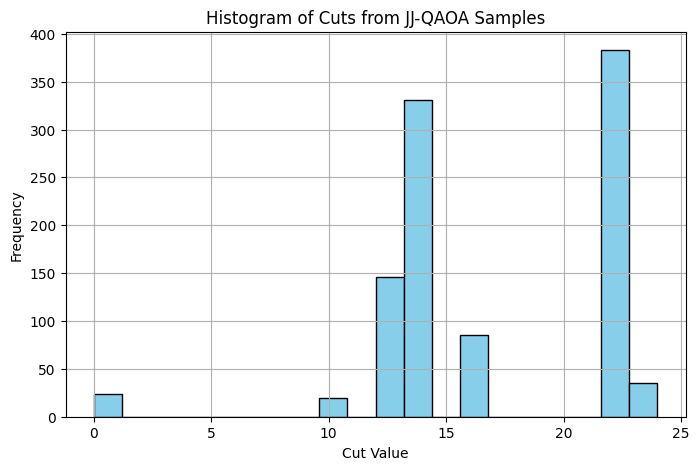

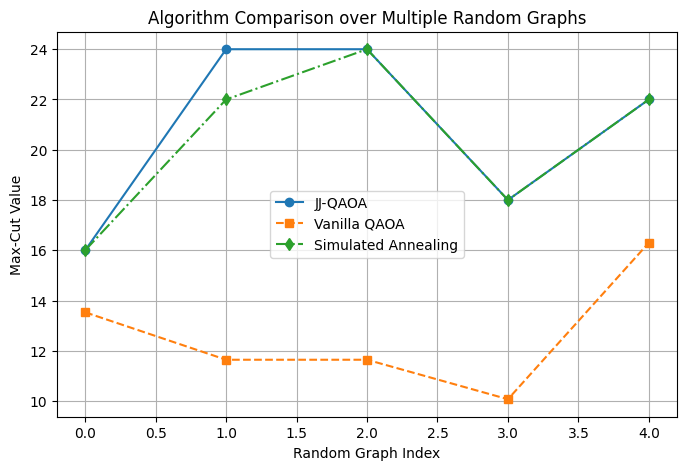

In [35]:
import numpy as np
import pennylane as qml
import networkx as nx
import matplotlib.pyplot as plt

# ------------------ JJ Physics ------------------
Phi0 = 2.067833848e-15
hbar = 1.0545718e-34
C = 6.35e-12
Ic0 = 9.489e-6

def deltaU(Ib, Ic):
    x = np.minimum(Ib/Ic, 0.999)
    return 2 * (Ic * Phi0 / (2*np.pi)) * (1-x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C*Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2*np.pi)) * prefactor * np.exp(exponent)

# ------------------ Graph / Ising mapping ------------------
def graph_to_Ising_J(G):
    A = nx.to_numpy_array(G)
    return -0.5 * A

def cut_value(s, G):
    A = nx.to_numpy_array(G)
    return 0.5 * np.sum(A * (1 - np.outer(s,s)))

# ------------------ JJ-QAOA ------------------
def jj_qaoa_maxcut(G, n_layers=2, n_steps=50, verbose=True):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)
    J = graph_to_Ising_J(G)

    degrees = np.sum(A, axis=1)
    beta_scale = 0.5
    beta_init = beta_scale * degrees / np.max(degrees)

    dev = qml.device("default.qubit", wires=N)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if verbose and step % 10 == 0:
            print(f"Step {step}: exp_cut = {circuit(params):.4f}")

    dev_sample = qml.device("default.qubit", wires=N, shots=1024)
    @qml.qnode(dev_sample)
    def sample_circuit():
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        return qml.sample(wires=range(N))

    samples = np.array(sample_circuit())
    cuts = [cut_value(1-2*s, G) for s in samples]
    best_cut = np.max(cuts)
    return best_cut, cuts, samples

# ------------------ Vanilla QAOA ------------------
def vanilla_qaoa_maxcut(G, n_layers=2, n_steps=50, verbose=True):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)

    dev = qml.device("default.qubit", wires=N)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p], wires=i)
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if verbose and step % 10 == 0:
            print(f"[Vanilla QAOA] Step {step}: exp_cut = {circuit(params):.4f}")

    return circuit(params)

# ------------------ Classical Simulated Annealing ------------------
def simulated_annealing(G, n_steps=1000, T_start=1.0, T_end=0.01, seed=None):
    rng = np.random.default_rng(seed)
    A = nx.to_numpy_array(G)
    N = len(G)
    s = rng.choice([-1,1], size=N)
    def energy(s):
        return -0.5 * np.sum(A * (1 - np.outer(s,s)))
    E = energy(s)
    best_s = s.copy()
    best_E = E
    temps = np.linspace(T_start, T_end, n_steps)
    for T in temps:
        i = rng.integers(0,N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = energy(s_new)
        if E_new < E or rng.random() < np.exp(-(E_new-E)/T):
            s = s_new
            E = E_new
            if E < best_E:
                best_E = E
                best_s = s.copy()
    return best_s, -best_E

# ------------------ Example and Plots ------------------
if __name__ == "__main__":
    G = nx.Graph()
    edges = [(0,1,3),(0,2,2),(1,2,4),(1,3,1),(2,3,5)]
    G.add_weighted_edges_from(edges)

    # Run algorithms
    jj_cut, jj_cuts, jj_samples = jj_qaoa_maxcut(G, n_layers=2, n_steps=50)
    v_cut = vanilla_qaoa_maxcut(G, n_layers=2, n_steps=50)
    sa_s, sa_cut = simulated_annealing(G, n_steps=1000)

    # Bar plot: max-cut comparison
    plt.figure(figsize=(8,5))
    methods = ["JJ-QAOA", "Vanilla QAOA", "Simulated Annealing"]
    cuts = [jj_cut, v_cut, sa_cut]
    plt.bar(methods, cuts, color=["skyblue", "lightgreen", "salmon"])
    plt.ylabel("Max-Cut Value")
    plt.title("Max-Cut Comparison: JJ-QAOA vs Vanilla QAOA vs Classical SA")
    plt.grid(axis="y")
    plt.show()

    # Histogram: JJ-QAOA samples
    plt.figure(figsize=(8,5))
    plt.hist(jj_cuts, bins=20, color="skyblue", edgecolor="black")
    plt.xlabel("Cut Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Cuts from JJ-QAOA Samples")
    plt.grid(True)
    plt.show()

    # Optional: Compare over multiple random graphs
    np.random.seed(42)
    n_graphs = 5
    jj_vals, v_vals, sa_vals = [], [], []
    for _ in range(n_graphs):
        G_rand = nx.erdos_renyi_graph(4, 0.8)
        for (i,j) in G_rand.edges():
            G_rand[i][j]["weight"] = np.random.randint(1,5)
        jj_val, _, _ = jj_qaoa_maxcut(G_rand, n_layers=2, n_steps=30, verbose=False)
        v_val = vanilla_qaoa_maxcut(G_rand, n_layers=2, n_steps=30, verbose=False)
        _, sa_val = simulated_annealing(G_rand, n_steps=500)
        jj_vals.append(jj_val)
        v_vals.append(v_val)
        sa_vals.append(sa_val)

    plt.figure(figsize=(8,5))
    plt.plot(range(n_graphs), jj_vals, "o-", label="JJ-QAOA")
    plt.plot(range(n_graphs), v_vals, "s--", label="Vanilla QAOA")
    plt.plot(range(n_graphs), sa_vals, "d-.", label="Simulated Annealing")
    plt.xlabel("Random Graph Index")
    plt.ylabel("Max-Cut Value")
    plt.title("Algorithm Comparison over Multiple Random Graphs")
    plt.legend()
    plt.grid(True)
    plt.show()


Step 0: exp_cut = 17.1155
Step 10: exp_cut = 17.1155
Step 20: exp_cut = 17.1155
Step 30: exp_cut = 17.1155
Step 40: exp_cut = 17.1155
JJ-QAOA Best Cut Value: 24.0
Best Partition (±1): [-1  1 -1  1]


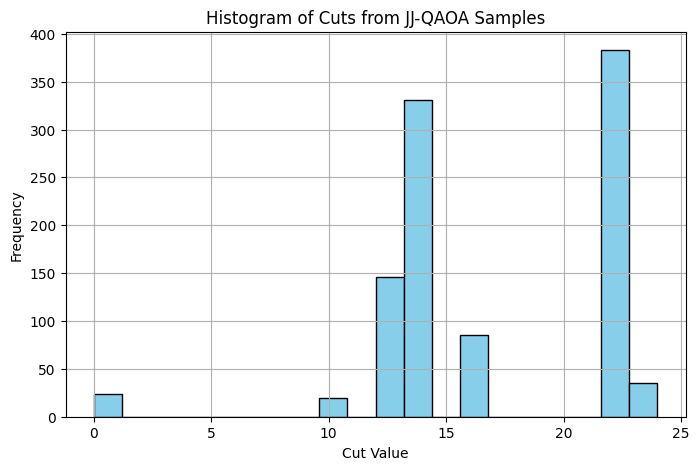

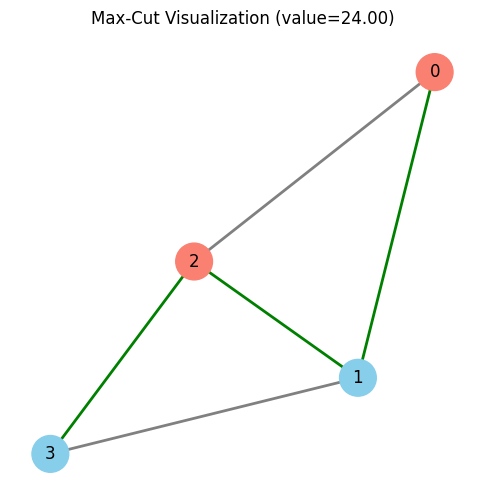

In [36]:
import numpy as np
import pennylane as qml
import networkx as nx
import matplotlib.pyplot as plt

# ------------------ JJ Physics ------------------
Phi0 = 2.067833848e-15
hbar = 1.0545718e-34
C = 6.35e-12
Ic0 = 9.489e-6

def deltaU(Ib, Ic):
    x = np.minimum(Ib/Ic, 0.999)
    return 2 * (Ic * Phi0 / (2*np.pi)) * (1-x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C*Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2*np.pi)) * prefactor * np.exp(exponent)

# ------------------ Graph / Ising mapping ------------------
def graph_to_Ising_J(G):
    A = nx.to_numpy_array(G)
    return -0.5 * A

def cut_value(s, G):
    A = nx.to_numpy_array(G)
    return 0.5 * np.sum(A * (1 - np.outer(s,s)))

# ------------------ JJ-QAOA ------------------
def jj_qaoa_maxcut(G, n_layers=2, n_steps=50, verbose=True):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)

    degrees = np.sum(A, axis=1)
    beta_scale = 0.5
    beta_init = beta_scale * degrees / np.max(degrees)

    dev = qml.device("default.qubit", wires=N)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if verbose and step % 10 == 0:
            print(f"Step {step}: exp_cut = {circuit(params):.4f}")

    dev_sample = qml.device("default.qubit", wires=N, shots=1024)
    @qml.qnode(dev_sample)
    def sample_circuit():
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        return qml.sample(wires=range(N))

    samples = np.array(sample_circuit())
    cuts = [cut_value(1-2*s, G) for s in samples]
    best_idx = np.argmax(cuts)
    best_cut = cuts[best_idx]
    best_sample = 1 - 2*samples[best_idx]  # convert 0/1 to ±1

    return best_cut, best_sample, cuts, samples

# ------------------ Graph Visualization ------------------
def plot_graph_maxcut(G, s):
    pos = nx.spring_layout(G, seed=42)
    cut_edges = [(i,j) for i,j in G.edges() if s[i] != s[j]]
    same_edges = [(i,j) for i,j in G.edges() if s[i] == s[j]]

    plt.figure(figsize=(6,6))
    nx.draw_networkx_nodes(G, pos, node_color=["skyblue" if s[i]==1 else "salmon" for i in G.nodes()], node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=same_edges, width=2, edge_color="gray")
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, width=2, edge_color="green")
    nx.draw_networkx_labels(G, pos)
    plt.title(f"Max-Cut Visualization (value={cut_value(s,G):.2f})")
    plt.axis("off")
    plt.show()

# ------------------ Example Usage ------------------
if __name__ == "__main__":
    # Example weighted graph
    G = nx.Graph()
    edges = [(0,1,3),(0,2,2),(1,2,4),(1,3,1),(2,3,5)]
    G.add_weighted_edges_from(edges)

    best_cut, best_sample, cuts, samples = jj_qaoa_maxcut(G, n_layers=2, n_steps=50)
    print("JJ-QAOA Best Cut Value:", best_cut)
    print("Best Partition (±1):", best_sample)

    # Histogram of sampled cuts
    plt.figure(figsize=(8,5))
    plt.hist(cuts, bins=20, color="skyblue", edgecolor="black")
    plt.xlabel("Cut Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of Cuts from JJ-QAOA Samples")
    plt.grid(True)
    plt.show()

    # Plot graph highlighting the max-cut
    plot_graph_maxcut(G, best_sample)


/usr/local/lib/python3.12/dist-packages/pennylane/devices/legacy_facade.py:177: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step 0: exp_cut = 16.9219
Step 10: exp_cut = 17.3418
Step 20: exp_cut = 17.0938
Step 30: exp_cut = 17.0410
Step 40: exp_cut = 17.2188
JJ-QAOA Best cut on Aer: 24.0


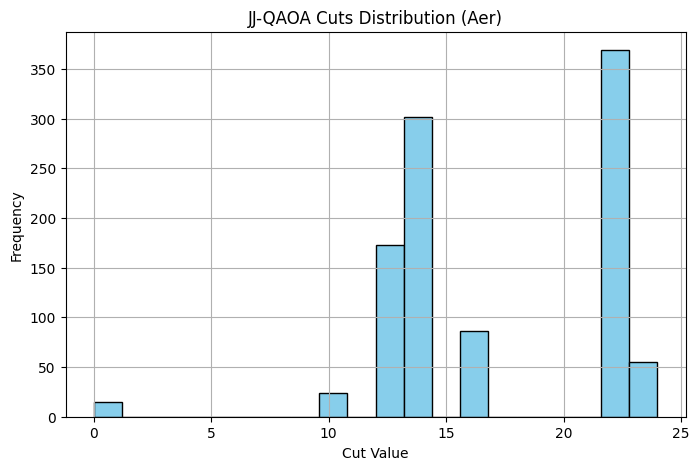

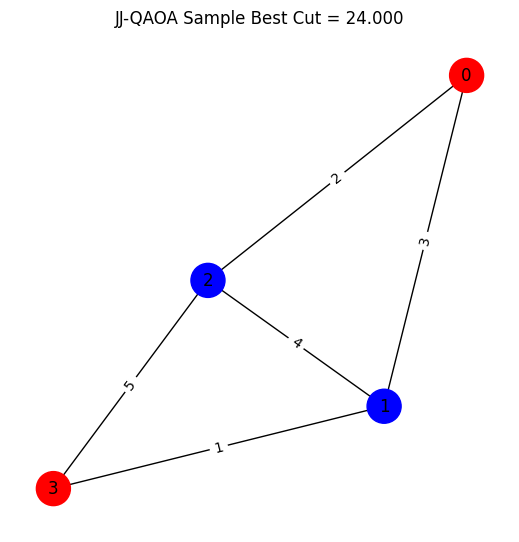

In [37]:
import numpy as np
import pennylane as qml
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

# ------------------ JJ Physics ------------------
Phi0 = 2.067833848e-15
hbar = 1.0545718e-34
C = 6.35e-12
Ic0 = 9.489e-6

def deltaU(Ib, Ic):
    x = np.minimum(Ib/Ic, 0.999)
    return 2 * (Ic * Phi0 / (2*np.pi)) * (1-x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C*Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2*np.pi)) * prefactor * np.exp(exponent)

# ------------------ Graph / Ising mapping ------------------
def graph_to_Ising_J(G):
    A = nx.to_numpy_array(G)
    return -0.5 * A

def cut_value(s, G):
    A = nx.to_numpy_array(G)
    return 0.5 * np.sum(A * (1 - np.outer(s,s)))

# ------------------ JJ-QAOA with Qiskit Aer ------------------
def jj_qaoa_maxcut_aer(G, n_layers=2, n_steps=50):
    N = len(G)
    A = nx.to_numpy_array(G)
    edges = np.argwhere(A > 0)
    J = graph_to_Ising_J(G)

    # JJ-inspired mixer amplitudes
    degrees = np.sum(A, axis=1)
    beta_scale = 0.5
    beta_init = beta_scale * degrees / np.max(degrees)

    # Use Qiskit Aer device
    dev = qml.device("qiskit.aer", wires=N, backend=AerSimulator(), shots=1024)

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        # Initial |+> state
        for i in range(N):
            qml.Hadamard(wires=i)
        # Alternating layers
        for p in range(n_layers):
            # Cost Hamiltonian
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            # JJ mixer
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        # Expectation value of cost Hamiltonian
        H = 0
        for (i,j) in edges:
            H += 0.5 * A[i,j] * (1 - qml.PauliZ(i)@qml.PauliZ(j))
        return qml.expval(H)

    # Initialize parameters
    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    # Gradient Descent optimization
    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if step % 10 == 0:
            print(f"Step {step}: exp_cut = {circuit(params):.4f}")

    # Sampling final circuit
    @qml.qnode(dev)
    def sample_circuit():
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for (i,j) in edges:
                qml.CNOT(wires=[i,j])
                qml.RZ(-2 * gammas[p] * A[i,j], wires=j)
                qml.CNOT(wires=[i,j])
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        return qml.sample(wires=range(N))

    samples = np.array(sample_circuit())
    cuts = [cut_value(1-2*s, G) for s in samples]
    best_cut = np.max(cuts)
    return best_cut, cuts, samples

# ------------------ Example Graph ------------------
G = nx.Graph()
edges = [(0,1,3),(0,2,2),(1,2,4),(1,3,1),(2,3,5)]
G.add_weighted_edges_from(edges)

# ------------------ Run JJ-QAOA on Aer ------------------
best_cut, cuts, samples = jj_qaoa_maxcut_aer(G, n_layers=2, n_steps=50)
print("JJ-QAOA Best cut on Aer:", best_cut)

# ------------------ Plots ------------------
plt.figure(figsize=(8,5))
plt.hist(cuts, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Cut Value")
plt.ylabel("Frequency")
plt.title("JJ-QAOA Cuts Distribution (Aer)")
plt.grid(True)
plt.show()

pos = nx.spring_layout(G, seed=42)
colors = ["red" if s>0 else "blue" for s in 1-2*samples[0]]
plt.figure(figsize=(5,5))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=600)
labels = nx.get_edge_attributes(G,"weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title(f"JJ-QAOA Sample Best Cut = {best_cut:.3f}")
plt.show()


Values: [7 4 8 5 7]
Weights: [3 7 8 5 4]
Capacity: 15
Step 0: expected value = 13.6885
Step 10: expected value = 14.3789
Step 20: expected value = 14.2861
Step 30: expected value = 13.9375
Step 40: expected value = 13.9414
JJ-QAOA Best: 1409.0
Greedy Best: 19
SA Best: 22


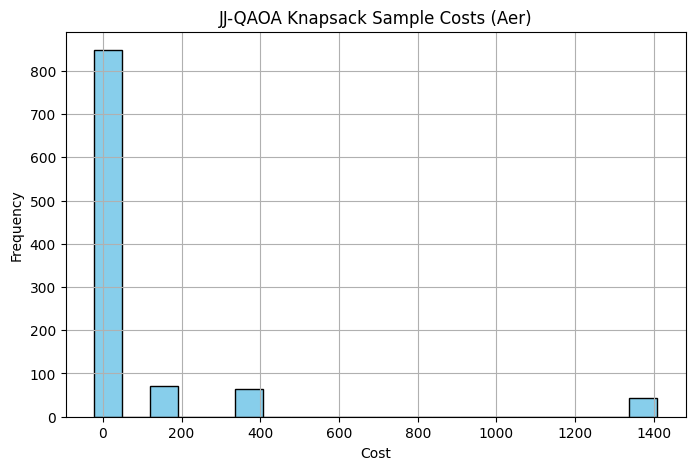

In [39]:
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator

# ------------------ Knapsack Problem ------------------
np.random.seed(42)
N = 5  # number of items
values = np.random.randint(1, 10, N)
weights = np.random.randint(1, 10, N)
capacity = 15
penalty = 10.0  # penalty for exceeding capacity

print("Values:", values)
print("Weights:", weights)
print("Capacity:", capacity)

# ------------------ Josephson Junction Physics ------------------
Phi0 = 2.067833848e-15
hbar = 1.0545718e-34
C = 6.35e-12
Ic0 = 9.489e-6

def deltaU(Ib, Ic):
    x = np.minimum(Ib/Ic, 0.999)
    return 2 * (Ic * Phi0 / (2*np.pi)) * (1-x)**1.5

def omega_p(Ib, Ic):
    wp0 = np.sqrt(2 * np.pi * Ic / (C*Phi0))
    factor = np.maximum(1 - (Ib/Ic)**2, 1e-6)
    return wp0 * factor**0.25

def gamma_q(Ib, Ic):
    DU = deltaU(Ib, Ic)
    wp = omega_p(Ib, Ic)
    prefactor = np.sqrt(864 * np.pi * DU / (hbar * wp))
    exponent = -36 * DU / (5 * hbar * wp)
    return (wp / (2*np.pi)) * prefactor * np.exp(exponent)

# ------------------ Cost Function (Knapsack) ------------------
def knapsack_cost(x):
    x = np.array(x)
    total_weight = np.sum(weights * x)
    penalty_term = penalty * max(0, total_weight - capacity)**2
    return -np.sum(values * x) + penalty_term

# ------------------ JJ-QAOA Circuit ------------------
def jj_qaoa_knapsack(n_layers=2, n_steps=50):
    dev = qml.device("qiskit.aer", wires=N, backend=AerSimulator(), shots=1024)

    beta_init = np.ones(N) * 0.5  # simple JJ-inspired mixer

    @qml.qnode(dev)
    def circuit(params):
        gammas, betas = params
        # initialize |+> states
        for i in range(N):
            qml.Hadamard(wires=i)
        # p layers
        for p in range(n_layers):
            # Cost Hamiltonian: apply Z rotations proportional to values and penalty
            for i in range(N):
                qml.RZ(2*gammas[p]*values[i], wires=i)
            # penalty term for capacity
            total_weight_op = sum(weights[i]*qml.PauliZ(i) for i in range(N))
            penalty_angle = gammas[p] * penalty
            for i in range(N):
                qml.RZ(penalty_angle*weights[i], wires=i)
            # JJ mixer
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        # Return expectation of cost Hamiltonian (Z-basis)
        return qml.expval(sum(values[i]*(1-qml.PauliZ(i))/2 for i in range(N)))

    # Initialize parameters
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)

    opt = qml.GradientDescentOptimizer(stepsize=0.2)
    for step in range(n_steps):
        params = opt.step(circuit, params)
        if step % 10 == 0:
            print(f"Step {step}: expected value = {circuit(params):.4f}")

    # Sample final circuit
    @qml.qnode(dev)
    def sample_circuit():
        gammas, betas = params
        for i in range(N):
            qml.Hadamard(wires=i)
        for p in range(n_layers):
            for i in range(N):
                qml.RZ(2*gammas[p]*values[i], wires=i)
            for i in range(N):
                qml.RX(2 * betas[p] * beta_init[i], wires=i)
        return qml.sample(wires=range(N))

    samples = np.array(sample_circuit())
    costs = [knapsack_cost(1-2*s) for s in samples]
    best_cost = np.max(costs)
    return best_cost, costs, samples

# ------------------ Greedy Algorithm ------------------
def greedy_knapsack(values, weights, capacity):
    ratio = values/weights
    idx = np.argsort(-ratio)
    total_value, total_weight = 0, 0
    solution = np.zeros(len(values), dtype=int)
    for i in idx:
        if total_weight + weights[i] <= capacity:
            solution[i] = 1
            total_weight += weights[i]
            total_value += values[i]
    return total_value, solution

# ------------------ Simulated Annealing ------------------
def sa_knapsack(values, weights, capacity, n_steps=1000, T_start=5, T_end=0.01):
    N = len(values)
    rng = np.random.default_rng(42)
    x = rng.integers(0,2,size=N)
    def energy(x):
        total_weight = np.sum(weights*x)
        if total_weight > capacity:
            return -np.sum(values*x) + penalty*(total_weight-capacity)**2
        else:
            return -np.sum(values*x)
    E = energy(x)
    best_x = x.copy()
    best_E = E
    temps = np.linspace(T_start, T_end, n_steps)
    for T in temps:
        i = rng.integers(0,N)
        x_new = x.copy()
        x_new[i] ^= 1
        E_new = energy(x_new)
        if E_new < E or rng.random() < np.exp(-(E_new-E)/T):
            x = x_new
            E = E_new
            if E < best_E:
                best_x = x.copy()
                best_E = E
    return -best_E, best_x

# ------------------ Run All ------------------
best_jj, jj_costs, jj_samples = jj_qaoa_knapsack()
best_greedy, greedy_sol = greedy_knapsack(values, weights, capacity)
best_sa, sa_sol = sa_knapsack(values, weights, capacity)

print("JJ-QAOA Best:", best_jj)
print("Greedy Best:", best_greedy)
print("SA Best:", best_sa)

# ------------------ Plots ------------------
plt.figure(figsize=(8,5))
plt.hist(jj_costs, bins=20, color='skyblue', edgecolor='black')
plt.title("JJ-QAOA Knapsack Sample Costs (Aer)")
plt.xlabel("Cost")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
